# Property Rent Prediction

The purpose of this notebook is to develop a property rent estimation model, to help Inn the Neighborhood attract more renters on their platform. The end goal of this notebook is to present a model, that could be productionized for use on the company's webpage, allowing prospective renters to estimate the rental value of their property.


## Data validation

We begin by loading and inspecting the data, stored in the csv file `data/rentals.csv`.

In [1]:
import pandas as pd

data = pd.read_csv("data/rentals.csv", index_col="id")
data.head()

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
id,,,,,,,,
958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


After loading the data, the first thing we can check are possible missing values.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8111 entries, 958 to 39354181
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   latitude        8111 non-null   float64
 1   longitude       8111 non-null   float64
 2   property_type   8111 non-null   object 
 3   room_type       8111 non-null   object 
 4   bathrooms       8099 non-null   float64
 5   bedrooms        8107 non-null   float64
 6   minimum_nights  8111 non-null   int64  
 7   price           8111 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 570.3+ KB


We have a total of 8111 observations, and a few observations where either `bathrooms` or `bedrooms` are null. As these represent a very small fraction of the total size of the dataset, imputing/removing the values has a very minor impact. Let us assume that these values are null because the observations have 0 bedrooms/bathrooms, and hence impute with 0s.

In [3]:
data = data.fillna(0)

After doing that, we should also fix the datatypes of some columns. Namely, `property_type` and `room_type` are categorical variables, and should hence be represented as categories. The `price` column currently has string values, that would be better expressed as floating point numbers.

In [4]:
data[["property_type", "room_type"]] = data[["property_type", "room_type"]].apply(lambda c: c.astype("category"))
data["price"] = data["price"].str.replace("$", "").str.replace(",", "").astype(float)
data

,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
id,,,,,,,,
958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0
...,...,...,...,...,...,...,...,...
39342094,37.74010,-122.41196,House,Private room,2.0,3.0,30,699.0
39343373,37.77799,-122.42159,Condominium,Entire home/apt,1.0,1.0,1,200.0
39344101,37.73410,-122.38917,Hut,Private room,2.0,1.0,30,69.0


After doing basic cleaning, let us first validate our numerical values, to ensure that the values are sensible.

In [5]:
data.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,8111.000000,8111.000000,8111.000000,8111.000000,8.111000e+03,8111.000000
mean,37.766054,-122.430107,1.393910,1.345210,1.234526e+04,225.407101
std,0.022937,0.026967,0.924089,0.925553,1.110357e+06,412.253039
min,37.704630,-122.513060,0.000000,0.000000,1.000000e+00,0.000000
25%,37.751450,-122.442830,1.000000,1.000000,2.000000e+00,100.000000
50%,37.769150,-122.424650,1.000000,1.000000,4.000000e+00,150.000000
75%,37.785670,-122.410615,1.500000,2.000000,3.000000e+01,240.000000
max,37.828790,-122.368570,14.000000,14.000000,1.000000e+08,10000.000000


Most of the values appear quite reasonable - latitude and longitude are within similar ranges, and hence properties in the data appear to be located quite close by. We should also note this in further analysis, as our dataset might not generalize too well outside this particular area.

We have some observations where the number of bathrooms, bedrooms, minimum nights and price are quite high. Likewise, we have observations where these quantities are oddly low. As a heuristic approach, we can remove observations where any one of these features lies outside three standard deviations of the respective features' means, essentially removing outliers.

In [6]:
import numpy as np

data = data[data.select_dtypes(include=[np.number]).apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

After removing the outliers, we can do a sanity check with our transformed data.

In [7]:
data.describe()

,latitude,longitude,bathrooms,bedrooms,minimum_nights,price
count,7844.000000,7844.000000,7844.000000,7844.000000,7844.000000,7844.000000
mean,37.765688,-122.430165,1.284357,1.320755,16.081591,200.394442
std,0.022918,0.027181,0.567905,0.864163,24.379725,166.162651
min,37.704630,-122.510150,0.000000,0.000000,1.000000,0.000000
25%,37.751140,-122.442870,1.000000,1.000000,2.000000,100.000000
50%,37.768260,-122.424810,1.000000,1.000000,4.000000,150.000000
75%,37.785283,-122.410530,1.500000,2.000000,30.000000,239.000000
max,37.828790,-122.368570,4.000000,4.000000,1000.000000,1451.000000


Now, our data should be more applicable to the wide customer base that we're interested in.

Besides numerical variables, we should also look at categoricals. We can do that by counting the amount of unique values.

In [8]:
data['property_type'].value_counts()

Apartment             3184
House                 2198
Condominium            881
Guest suite            577
Boutique hotel         256
Hotel                  155
Townhouse              140
Serviced apartment     119
Loft                    88
Hostel                  65
Guesthouse              41
Aparthotel              30
Other                   23
Bed and breakfast       19
Bungalow                17
Resort                  14
Cottage                 12
Villa                    9
Castle                   4
Cabin                    3
Tiny house               3
Earth house              2
Dome house               1
Camper/RV                1
Hut                      1
In-law                   1
Name: property_type, dtype: int64

In [9]:
data['room_type'].value_counts()

Entire home/apt    4687
Private room       2778
Shared room         201
Hotel room          178
Name: room_type, dtype: int64

Room types seem to be in order, although we have a few smaller categories. As for property types, we should handle some less common property types with care. One way, that we could handle them, would be to define an "other" category. Again, somewhat heuristically, let us put all types that individually represent less than 1% of total observation into a single "other" category.

In [10]:
infrequent_property_types = data["property_type"].value_counts()[data["property_type"].value_counts() < len(data) / 100].index

data["property_type"] = data["property_type"].apply(lambda x: "Other" if x in infrequent_property_types else x)
data["property_type"].value_counts()

Apartment             3184
House                 2198
Condominium            881
Guest suite            577
Boutique hotel         256
Other                  246
Hotel                  155
Townhouse              140
Serviced apartment     119
Loft                    88
Name: property_type, dtype: int64

After the transformation, we have a much nicer distribution of different property types, with a reasonable amount of observations per each category. As a final touch, we can convert the data frame column names into nicer names.

In [11]:
data.columns = ["Latitude", "Longitude", "Property type", "Room type", "Bathrooms", "Bedrooms", "Minimum nights", "Price $"]
data.head()

,Latitude,Longitude,Property type,Room type,Bathrooms,Bedrooms,Minimum nights,Price $
id,,,,,,,,
958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,170.0
3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,99.0
5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,235.0
7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,65.0
8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,65.0


## Data visualization

Having transformed the data, we can next conduct some exploratory data analysis by visualizing the data. Lets first look at the relationship between room types and price.

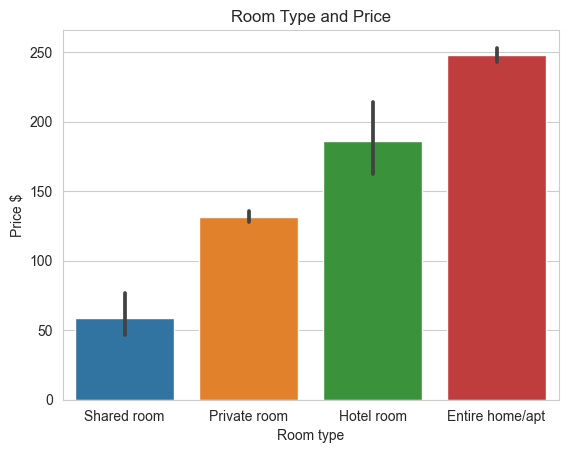

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

sns.barplot(data=data, x="Room type", y="Price $", order=data.groupby("Room type")["Price $"].mean().sort_values().index).set_title("Room Type and Price")
plt.show()

One can observe that entire homes/apartments are most expensive, which can be expected as they are both private (which renters might in general prefer), and comparatively larger than individual rooms. Second up are hotel rooms, which might command a higher price than rooms rented by individuals. Not unexpectedly, shared rooms are the cheapest.

Next up, let us look at the relationship between property type and price.

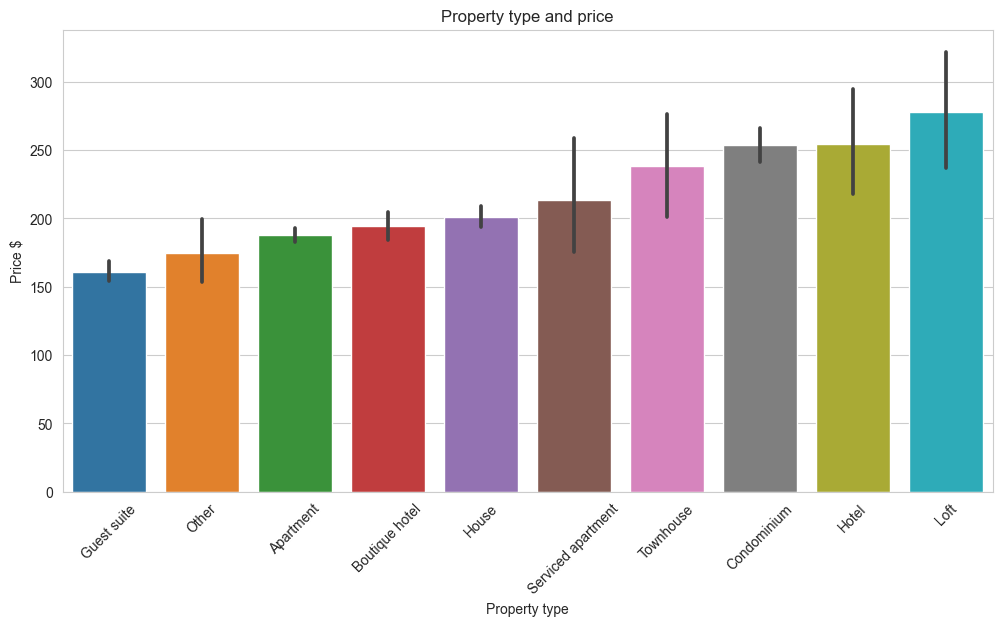

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.tick_params(axis='x', rotation=45)

sns.barplot(data=data, ax=ax, x="Property type", y="Price $", order=data.groupby("Property type")["Price $"].mean().sort_values().index).set_title("Property type and price")
plt.show()

We can observe that different property types also have quite different average price points for rental.

Next, let us look at the relationship between the number of bedrooms and rental price.

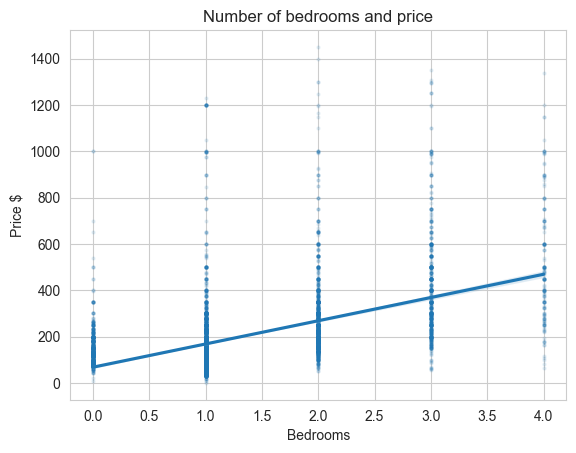

In [14]:
sns.regplot(data=data, x="Bedrooms", y="Price $", scatter_kws={"s": 4, "alpha": 0.1}).set_title("Number of bedrooms and price")
plt.show()

Price seems to increase with the amount of bedrooms, as perhaps expected. There seem to be outliers across all bedroom categories.

Finally, let us look at the geographic distribution of the rental properties.

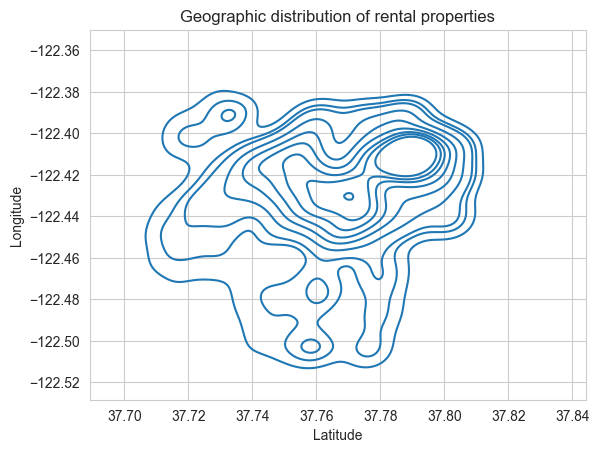

In [15]:
sns.kdeplot(data=data, x="Latitude", y="Longitude").set_title("Geographic distribution of rental properties")
plt.show()

The properties seem to cluster quite heavily in certain regions. The central takeaway from the plot is to observe that we don't have any observations outside the drawn region. The key implication of this is that our model won't generalize well outside those boundaries - and is hence only fully applicable within this geographic region.

## Model fitting

As we're trying to predict rental prices, we're dealing with a *regression* problem. We will be using scikit-learn for modelling, and use a Random Forest Regressor. We expect that this model could be a good fit for the problem, as it can account well, for example, for possible nonlinear effects that latitude and longitude might have with respect to house prices.

Our performance criteria is being able to predict a rent within $25 of the real rent in data. Based on this, we can make a scoring function as follows:

$$ \text{Score} = \frac{1}{n} \sum_{i=1}^n s_i, s_i := \begin{cases}1 \quad \text{if}\;  | y_i - \hat y_i | \leq 25 \\ 0 \quad \text{otherwise} \end{cases}$$


In [16]:
from sklearn.metrics import make_scorer

def score_model(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 25) / len(y_true)

As a final adjustment before we fit our models, we need to convert our categorical variables to dummy indicators with one-hot encoding. We also need to train-test-split the data. With around 8000 entries, a split of 80/20 should be reasonable - we will get around 6400 training examples, and 1600 to test on.

In [17]:
X = data.drop("Price $", axis=1)
y = data["Price $"]

X = pd.get_dummies(X)
X.head()

,Latitude,Longitude,Bathrooms,Bedrooms,Minimum nights,Property type_Apartment,Property type_Boutique hotel,Property type_Condominium,Property type_Guest suite,Property type_Hotel,Property type_House,Property type_Loft,Property type_Other,Property type_Serviced apartment,Property type_Townhouse,Room type_Entire home/apt,Room type_Hotel room,Room type_Private room,Room type_Shared room
id,,,,,,,,,,,,,,,,,,,
958,37.76931,-122.43386,1.0,1.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3850,37.75402,-122.45805,1.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
5858,37.74511,-122.42102,1.0,2.0,30,1,0,0,0,0,0,0,0,0,0,1,0,0,0
7918,37.76669,-122.45250,4.0,1.0,32,1,0,0,0,0,0,0,0,0,0,0,0,1,0
8142,37.76487,-122.45183,4.0,1.0,32,1,0,0,0,0,0,0,0,0,0,0,0,1,0


Our dummy variables look OK.

Let us do the train-test split.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

After splitting, we will first fit our baseline model and score it on test data.

In [19]:
from sklearn.linear_model import LinearRegression

model_baseline = LinearRegression()
model_baseline.fit(X_train, y_train)
score_model(y_test, model_baseline.predict(X_test))

0.29063097514340347

Score on the baseline linear model doesn't appear too impressive. We have only managed to classify around 29% of observations within 25$ of the real price.

Lets proceed to trying with a random forest regressor.

In [20]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, n_estimators=1000, oob_score=True, random_state=42)
model.fit(X_train, y_train)
score_model(y_test, model.predict(X_test))

0.420012746972594

While the results are still not particularly impressive, we have achieved quite a large increase in the metric. Now we have a reasonable result for around 42% of predictions. The better score is likely to due to the fact that random forest regressors can correctly account for nonlinear features unlike linear regression.

## Model evaluation

We can plot to how large extent each of the models misclassified prices.

In [21]:
plot_data_baseline = pd.DataFrame({"$ Difference to actual price": y_test - model_baseline.predict(X_test), "Within $25": (np.abs(y_test - model_baseline.predict(X_test)) <= 25)})
plot_data_final = pd.DataFrame({"$ Difference to actual price": y_test - model.predict(X_test), "Within $25": (np.abs(y_test - model.predict(X_test)) <= 25)})

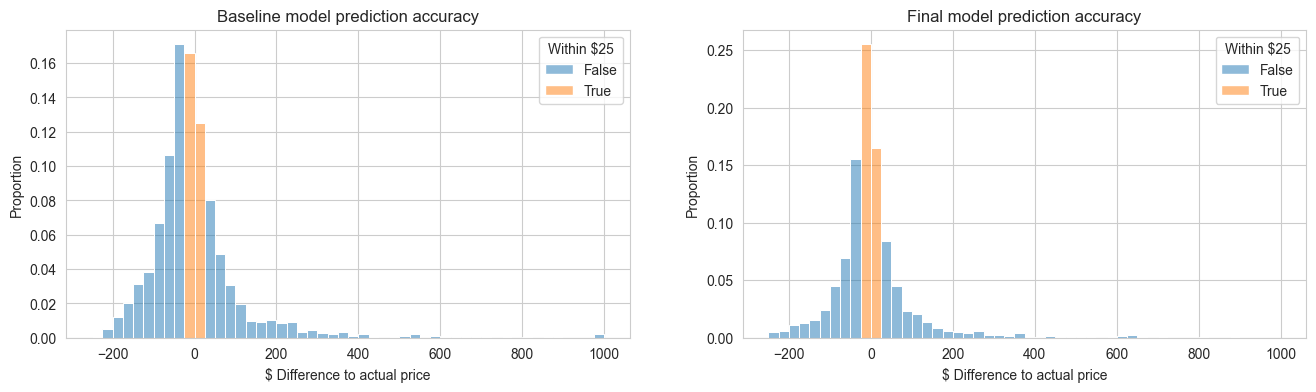

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))

sns.histplot(ax=ax[0], data=plot_data_baseline, x="$ Difference to actual price", hue="Within $25", binwidth=25, binrange=(-250, 1000), stat="proportion").set_title("Baseline model prediction accuracy")
sns.histplot(ax=ax[1], data=plot_data_final, x="$ Difference to actual price", hue="Within $25", binwidth=25, binrange=(-250, 1000), stat="proportion").set_title("Final model prediction accuracy")

plt.show()

As can be seen in the plots, the final model is better at predicting values within difference of $25 from actual price, as a larger of the histogram observations fall within the range. Both of the models seem to exhibit a small negative bias with respect to actual price, with this effect appearing slightly more pronounced in the linear model.

One way to capture by how much exactly we are mispredicting price is by looking at two metrics:
- Mean absolute error: On average, how much do our predicted values differ from real values?
- Median absolute error: At 50th percentile, how much does our predicted value differ from real values?

Out of the two metrics, the first one tells us about the *average* magnitude of our mispredictions, while the latter is interesting because it essentially tells under which line of misclassification would half of rent predictions fall. This translates into direct business insight: this number tells us at least how accurate result 50% of customers would get (assuming customers are randomly sampled from population of renters, which our data would be representative of).

In [23]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error

plot_data_baseline = pd.Series({"MAE": mean_absolute_error(y_test, model_baseline.predict(X_test)), "MedAE": median_absolute_error(y_test, model_baseline.predict(X_test))})
plot_data_final = pd.Series({"MAE": mean_absolute_error(y_test, model.predict(X_test)), "MedAE": median_absolute_error(y_test, model.predict(X_test))})

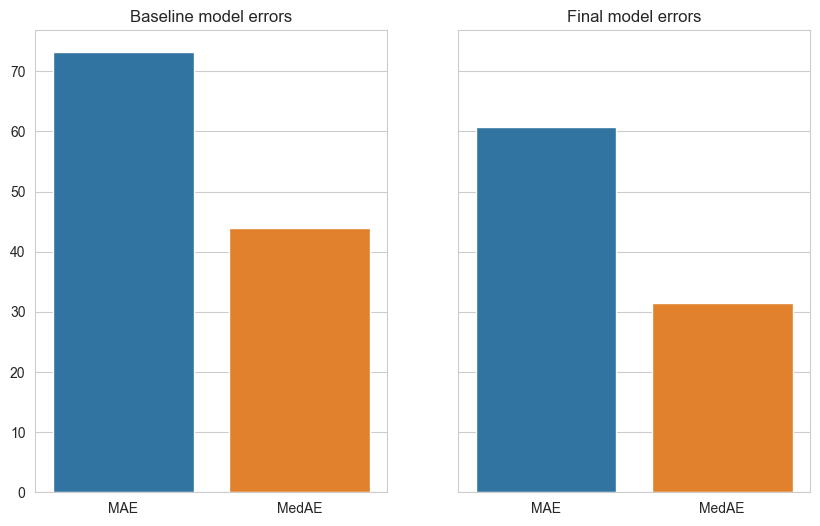

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6), sharey="all")

sns.barplot(ax=ax[0], x=plot_data_baseline.index, y=plot_data_baseline.values).set_title("Baseline model errors")
sns.barplot(ax=ax[1], x=plot_data_final.index, y=plot_data_final.values).set_title("Final model errors")
plt.show()

As can be seen in the plot, for both models the mean absolute error is somewhat higher than the median. This is expected as it's more impacted by outliers. For the final model, we have a median absolute error of around 34 dollars. While this is not quite yet at 25 dollars, it's a clear improvement over the baseline model.

## Conclusion

A model for predicting (regressing) rental prices was developed. Currently, the model is best applied in the area from where the original rent prices were acquired. The model should not be used outside the area of the original observations, as unexpected results may ensue.

The model performed reasonably, but did not fully meet the original expectations of being able to classify within $25 of actual rental price in a majority of cases. However, 42% of cases were within the limit in test data. This result is quite promising, and already presents a significant improvement over having no model at all. On average, the misprediction is 60 dollars with the current model.

Future effort should be put into acquiring more data to make the model more general for other cities/markets. In addition, more effort could be put into making the model more accurate, for example through careful feature selection and engineering, as well as hyperparameter tuning. It might also be interesting to test other modeling frameworks such as gradient boosting, although it cannot be stated in advance whether performance would necessarily improve.